# BanditPAM (Image Demo)

<img src='https://storage.googleapis.com/tfds-data/visualization/fig/imagenette-160px-v2-1.0.0.png' width='250'>

In [1]:
from banditpam import KMedoids
from sklearn.cluster import KMeans        # for comparison

import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

## Data preparation

In [14]:
# download an image dataset
! wget https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-160.tgz

--2022-01-19 00:04:00--  https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-160.tgz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.113.53
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.113.53|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 99003388 (94M) [application/x-tar]
Saving to: ‘imagenette2-160.tgz’

imagenette2-160.tgz 100%[===================>]  94.42M  10.7MB/s    in 9.5s    

2022-01-19 00:04:10 (9.98 MB/s) - ‘imagenette2-160.tgz’ saved [99003388/99003388]



In [21]:
# extract the dataset
! tar xf imagenette2-160.tgz -C data/

Example of one image from the dataset:  
<img src='data/imagenette2-160/train/n01440764/ILSVRC2012_val_00000293.JPEG'>

In [2]:
files_basedir = Path('data') / 'imagenette2-160' / 'train' 

In [3]:
files = sorted(files_basedir.glob('n0*/*'))

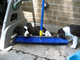

In [4]:
from PIL import Image
im = Image.open(files[1200])
# reduce size further
im.thumbnail((80,80), Image.ANTIALIAS)
im.show()

In [5]:
# to array
np.asarray(im).shape

(60, 80, 3)

In [6]:
def crop_center(im, crop_width, crop_height):
    img_width, img_height = im.size
    return im.crop(((img_width - crop_width) // 2,
                    (img_height - crop_height) // 2,
                    (img_width + crop_width) // 2,
                    (img_height + crop_height) // 2))

In [47]:
def process(p: Path) -> np.ndarray:
    """load image and return flattened ndarray"""
    im = Image.open(p)
    #im.thumbnail((80,80), Image.ANTIALIAS)
    im = crop_center(im, 80, 80)
    flattened = np.asarray(im).ravel()
    #if len(flattened) == 60*60:
    return flattened

In [52]:
raw = [process(f) for f in files]

In [53]:
X = np.vstack([r for r in raw if len(r) == 80*80*3])[::10] # subsample by 10

In [54]:
X.shape

(930, 19200)

In [55]:
# Fit the data with KMeans (sklearn)
kmean = KMeans(n_clusters=10)
kmean.fit(X, 'L2')
kmean.labels_

array([9, 9, 3, 8, 4, 9, 8, 4, 4, 9, 3, 5, 1, 8, 1, 0, 8, 8, 9, 8, 8, 8,
       8, 5, 1, 9, 9, 9, 9, 7, 3, 8, 7, 9, 3, 0, 1, 4, 9, 8, 9, 7, 0, 9,
       8, 8, 7, 9, 5, 8, 3, 8, 9, 9, 9, 4, 0, 8, 9, 3, 5, 0, 8, 8, 4, 0,
       3, 9, 6, 7, 9, 9, 1, 8, 6, 9, 8, 7, 1, 3, 9, 9, 8, 3, 0, 7, 8, 3,
       8, 8, 9, 1, 0, 3, 3, 4, 0, 3, 7, 3, 7, 1, 6, 2, 6, 9, 7, 5, 3, 8,
       3, 7, 5, 2, 8, 1, 7, 8, 8, 8, 2, 9, 5, 8, 8, 8, 2, 7, 5, 8, 3, 7,
       5, 7, 4, 3, 8, 1, 7, 3, 0, 5, 5, 2, 3, 7, 8, 5, 3, 0, 3, 8, 5, 5,
       8, 4, 9, 4, 8, 7, 7, 8, 1, 1, 9, 7, 7, 7, 7, 0, 7, 1, 8, 3, 7, 1,
       3, 8, 3, 7, 1, 3, 8, 8, 7, 5, 5, 7, 5, 0, 3, 7, 3, 1, 0, 1, 6, 7,
       2, 2, 2, 1, 6, 6, 8, 1, 8, 5, 0, 1, 4, 1, 9, 8, 5, 8, 0, 0, 8, 3,
       8, 4, 5, 8, 7, 7, 8, 0, 0, 0, 0, 1, 0, 4, 0, 7, 0, 8, 8, 9, 1, 1,
       0, 2, 1, 4, 1, 3, 2, 2, 0, 7, 6, 4, 4, 1, 5, 2, 0, 3, 4, 0, 1, 9,
       1, 5, 1, 6, 2, 5, 1, 5, 5, 1, 2, 2, 1, 6, 1, 3, 4, 1, 1, 4, 3, 1,
       1, 2, 6, 1, 5, 9, 3, 2, 9, 4, 2, 4, 5, 3, 7,

In [56]:
kmean.cluster_centers_.shape

(10, 19200)

In [70]:
class_id = 0

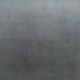

In [71]:
kmean.cluster_centers_
Image.fromarray(np.uint8(kmean.cluster_centers_[class_id]).reshape((80,80,3)))

## K-Mediods

In [72]:
# Fit the data with BanditPAM:
kmed = KMedoids(n_medoids=10, algorithm="BanditPAM")
kmed.fit(X, 'L2')

In [73]:
kmed.medoids

array([851, 273, 889, 830, 637, 432, 883, 276, 837, 881], dtype=uint64)

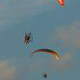

In [74]:
Image.fromarray(np.uint8(X[kmed.medoids[class_id]]).reshape((80,80,3)))